In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from abc import ABC, abstractmethod
# from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

plt.style.use('ggplot')
%matplotlib inline

# Abstract base class

In [43]:
class LaneChangePlanner(ABC):
    
    def __init__(self, lane_width=3.5, vehicle_length=4.5, vehicle_width=1.8):
        """
        Initialize the lane change planner
        
        Parameters:
            lane_width: Lane width in meters
            vehicle_length: Vehicle length in meters
            vehicle_width: Vehicle width in meters
        """
        self.lane_width = lane_width
        self.vehicle_length = vehicle_length
        self.vehicle_width = vehicle_width
    
    @abstractmethod
    def plan_trajectory(self, start_position, start_lane, target_lane, 
                        longitudinal_distance=30.0, num_points=20, **kwargs):
        """
        Plan a lane change trajectory
        
        Parameters:
            start_position: Starting position [x, y]
            start_lane: Starting lane number (0, 1, 2, ...)
            target_lane: Target lane number (0, 1, 2, ...)
            longitudinal_distance: Longitudinal distance to complete the lane change (meters)
            num_points: Number of waypoints to generate
            kwargs: Additional parameters specific to the planning method
            
        Returns:
            waypoints: Array of path points [[x1, y1], [x2, y2], ...]
            headings: Array of heading angles at each waypoint (in degrees)
        """
        pass
    
    def get_lane_center(self, lane_num):
        """Calculate the y-coordinate of the center of a lane"""
        return lane_num * self.lane_width + self.lane_width / 2


# Implements

## QuinticPolynomial

uses a 5th-degree polynomial to generate smooth lane change trajectories. The polynomial has the form:

$$s(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 + a_4 t^4 + a_5 t^5$$

where $t$ is a normalized time parameter from 0 to 1.

In [44]:
class QuinticPolynomialPlanner(LaneChangePlanner):
    
    def plan_trajectory(self, start_position, start_lane, target_lane, 
                        longitudinal_distance=30.0, num_points=20, **kwargs):
        """
        Additional kwargs:
            custom_boundary_conditions: Dictionary with custom boundary conditions
                                       {'v_start', 'v_end', 'a_start', 'a_end'}
        """
        start_y = self.get_lane_center(start_lane)
        target_y = self.get_lane_center(target_lane)
        
        # Get boundary conditions
        custom_bc = kwargs.get('custom_boundary_conditions', {})
        v_start = custom_bc.get('v_start', 0) 
        v_end = custom_bc.get('v_end', 0)    
        a_start = custom_bc.get('a_start', 0) 
        a_end = custom_bc.get('a_end', 0)   
        
        # Solve for quintic polynomial coefficients
        # s(t) = a0 + a1*t + a2*t^2 + a3*t^3 + a4*t^4 + a5*t^5
        # Boundary conditions:
        # s(0) = start_y, s'(0) = v_start, s''(0) = a_start
        # s(1) = target_y, s'(1) = v_end, s''(1) = a_end

        a0 = start_y
        a1 = v_start
        a2 = a_start / 2
        
        delta_y = target_y - start_y
        
        # For custom boundary conditions:
        a3 = 10 * delta_y - 6 * v_start - 3 * a_start / 2 - 4 * v_end + a_end / 2
        a4 = -15 * delta_y + 8 * v_start + 3 * a_start / 2 + 7 * v_end - a_end / 2
        a5 = 6 * delta_y - 3 * v_start - a_start / 2 - 3 * v_end + a_end / 2
        
        # Generate waypoints
        waypoints = []
        for i in range(num_points):
            t = i / (num_points - 1)  # normalized time [0, 1]
            x = start_position[0] + t * longitudinal_distance
            y = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5
            waypoints.append([x, y])
        
        waypoints = np.array(waypoints)

        headings = self._calculate_headings(waypoints)
        
        return waypoints, headings
    
    def _calculate_headings(self, waypoints):
        headings = []
        for i in range(len(waypoints)):
            if i < len(waypoints) - 1:
                dx = waypoints[i+1, 0] - waypoints[i, 0]
                dy = waypoints[i+1, 1] - waypoints[i, 1]
                heading = np.arctan2(dy, dx) * 180 / np.pi
            else:
                # For the last point, use the previous heading
                heading = headings[-1]
            headings.append(heading)
        
        return np.array(headings)

## CubicSpline

uses piecewise 3rd-degree polynomials connected at control points to create a continuous path. Each segment has the form:

$$s(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3$$

with different coefficients for each segment.

In [45]:
class CubicSplinePlanner(LaneChangePlanner):

    def plan_trajectory(self, start_position, start_lane, target_lane, 
                        longitudinal_distance=30.0, num_points=20, **kwargs):
        """
        Additional kwargs:
            control_points: List of [x, y] control points for the spline
            tension: Tension parameter for the spline (default: 0.5)
        """
        start_y = self.get_lane_center(start_lane)
        target_y = self.get_lane_center(target_lane)
        end_x = start_position[0] + longitudinal_distance

        control_points = kwargs.get('control_points', None)
        if control_points is None:
            # 4 control points
            control_points = [
                [start_position[0], start_y],  
                [start_position[0] + longitudinal_distance * 0.3, start_y + (target_y - start_y) * 0.1],  
                [start_position[0] + longitudinal_distance * 0.7, start_y + (target_y - start_y) * 0.9],  
                [end_x, target_y] 
            ]
        
        control_points = np.array(control_points)
        t_values = np.linspace(0, 1, num_points)
        
        # Generate waypoints using cubic spline interpolation
        waypoints = []
        for t in t_values:
            point = self._cubic_spline_interpolation(control_points, t)
            waypoints.append(point)
        
        waypoints = np.array(waypoints)
        
        # Calculate heading angles
        headings = self._calculate_headings(waypoints)
        
        return waypoints, headings
    
    def _cubic_spline_interpolation(self, control_points, t):
        """Interpolate a point on the cubic spline at parameter t"""
        n = len(control_points) - 1
        if n < 1:
            return control_points[0]
        
        # Find the segment
        segment = min(int(t * n), n - 1)
        t_local = t * n - segment

        p0 = control_points[segment]
        p1 = control_points[segment + 1]
        
        # Calculate tangents
        if segment > 0:
            tangent0 = (control_points[segment + 1] - control_points[segment - 1]) / 2
        else:
            tangent0 = control_points[segment + 1] - control_points[segment]
        
        if segment < n - 1:
            tangent1 = (control_points[segment + 2] - control_points[segment]) / 2
        else:
            tangent1 = control_points[segment + 1] - control_points[segment]

        h00 = 2*t_local**3 - 3*t_local**2 + 1
        h10 = t_local**3 - 2*t_local**2 + t_local
        h01 = -2*t_local**3 + 3*t_local**2
        h11 = t_local**3 - t_local**2

        point = h00 * p0 + h10 * tangent0 + h01 * p1 + h11 * tangent1
        
        return point
    
    def _calculate_headings(self, waypoints):
        headings = []
        for i in range(len(waypoints)):
            if i < len(waypoints) - 1:
                dx = waypoints[i+1, 0] - waypoints[i, 0]
                dy = waypoints[i+1, 1] - waypoints[i, 1]
                heading = np.arctan2(dy, dx) * 180 / np.pi
            else:
                # For the last point, use the previous heading
                heading = headings[-1]
            headings.append(heading)
        
        return np.array(headings)

## TrajectorySmoother

iterative weighted averaging

In [47]:
class TrajectorySmoother:
    
    @staticmethod
    def smooth_trajectory(waypoints, smoothing_factor=0.5, iterations=1):
        """
        Parameters:
            waypoints: Array of [x, y] waypoints
            smoothing_factor: Factor determining smoothing strength (0-1)
            iterations: Number of smoothing iterations
            
        Returns:
            smoothed_waypoints: Smoothed array of waypoints
        """
        if len(waypoints) <= 2:
            return waypoints
        
        smoothed = waypoints.copy()
        
        for _ in range(iterations):
            # Keep first and last points fixed
            for i in range(1, len(waypoints) - 1):
                smoothed[i] = (1 - smoothing_factor) * smoothed[i] + \
                              smoothing_factor * (smoothed[i-1] + smoothed[i+1]) / 2
        
        return smoothed

## Vis

In [48]:
class TrajectoryVisualizer:
    def __init__(self, lane_width=3.5, vehicle_length=4.5, vehicle_width=1.8):

        self.lane_width = lane_width
        self.vehicle_length = vehicle_length
        self.vehicle_width = vehicle_width
        
    def visualize_trajectory(self, waypoints, headings, start_lane, target_lane, 
                             show_table=False, show_all_waypoints=True, 
                             highlight_indices=None, title=None):
        """
        Parameters:
            waypoints: Array of path points [[x1, y1], [x2, y2], ...]
            headings: Array of heading angles at each waypoint (in degrees)
            start_lane: Starting lane number
            target_lane: Target lane number
            show_table: Whether to show a data table below the visualization
            show_all_waypoints: Whether to show all waypoints or just key ones
            highlight_indices: List of waypoint indices to highlight
            title: Custom title for the visualization
            
        Returns:
            fig: The matplotlib figure object
        """
        # Determine the number of lanes needed
        num_lanes = max(start_lane, target_lane) + 1
        
        if show_table:
            fig = plt.figure(figsize=(14, 10))
            gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
            ax_viz = plt.subplot(gs[0])
            ax_table = plt.subplot(gs[1])
        else:
            fig, ax_viz = plt.subplots(figsize=(14, 7))

        self._draw_road(ax_viz, num_lanes)
        ax_viz.plot(waypoints[:, 0], waypoints[:, 1], 'r-', linewidth=2, alpha=0.7, label='Path')
        
        # Determine which waypoints to show
        if highlight_indices is None:
            if show_all_waypoints:
                display_indices = list(range(len(waypoints)))
            else:
                display_indices = list(range(0, len(waypoints), len(waypoints) // 5))
                if len(waypoints) - 1 not in display_indices:
                    display_indices.append(len(waypoints) - 1)  # Always include the last point
        else:
            display_indices = highlight_indices

        self._draw_waypoints(ax_viz, waypoints, headings, display_indices)

        ax_viz.plot(waypoints[0, 0], waypoints[0, 1], 'go', markersize=10, label='Start')
        ax_viz.plot(waypoints[-1, 0], waypoints[-1, 1], 'bo', markersize=10, label='End')
        
        # Draw vehicles at key positions
        self._draw_vehicles(ax_viz, waypoints, headings, display_indices)
        ax_viz.set_xlim([-5, waypoints[-1, 0] + 5])
        ax_viz.set_ylim([0, num_lanes * self.lane_width + 1])
        ax_viz.set_xlabel('Longitudinal Distance (m)')
        ax_viz.set_ylabel('Lateral Distance (m)')
        
        if title:
            ax_viz.set_title(title, fontsize=14)
        else:
            ax_viz.set_title('Lane Change Trajectory Visualization', fontsize=14)
            
        ax_viz.grid(True, alpha=0.3)
        ax_viz.legend(loc='upper right')
        ax_viz.set_aspect('equal')
        
        if show_table:
            self._create_data_table(ax_table, waypoints, headings)
        
        plt.tight_layout()
        return fig
    
    def _draw_road(self, ax, num_lanes):
        for i in range(num_lanes + 1):
            y = i * self.lane_width
            ax.axhline(y=y, color='black', linestyle='-', alpha=0.5)
            
            # Add lane center markers
            if i < num_lanes:
                center_y = y + self.lane_width / 2
                ax.axhline(y=center_y, color='white', linestyle='--', alpha=0.7)
                # Add lane labels
                ax.text(-2, center_y, f"Lane {i}", 
                     fontsize=10, ha='center', va='center')
    
    def _draw_waypoints(self, ax, waypoints, headings, display_indices):
        for i in display_indices:
            x, y = waypoints[i]
            ax.plot(x, y, 'ro', markersize=5)
            if len(display_indices) <= 20 or i % 2 == 0 or i == len(waypoints)-1:
                ax.text(x+0.2, y+0.2, str(i), fontsize=9)
        
        # Draw heading arrows at selected waypoints
        arrow_indices = display_indices if len(display_indices) <= 10 else \
                       list(range(0, len(waypoints), len(waypoints) // 5))
        
        for i in arrow_indices:
            x, y = waypoints[i]
            heading_rad = headings[i] * np.pi / 180
            dx = np.cos(heading_rad) * 1.0  # Arrow length
            dy = np.sin(heading_rad) * 1.0
            ax.arrow(x, y, dx, dy, head_width=0.3, head_length=0.5, 
                  fc='blue', ec='blue', alpha=0.7)
    
    def _draw_vehicles(self, ax, waypoints, headings, display_indices):
        if len(display_indices) <= 5:
            vehicle_indices = display_indices
        else:
            # Choose start, end, and a few in between
            vehicle_indices = [0, len(waypoints) // 4, len(waypoints) // 2, 
                             3 * len(waypoints) // 4, len(waypoints) - 1]
        
        for idx in vehicle_indices:
            x, y = waypoints[idx]
            heading_rad = headings[idx] * np.pi / 180

            if idx == 0: 
                color = 'lightgreen'
                edge_color = 'green'
            elif idx == len(waypoints) - 1: 
                color = 'lightblue'
                edge_color = 'blue'
            else: 
                color = 'violet'
                edge_color = 'purple'
                
            alpha = 0.5 if idx not in [0, len(waypoints) - 1] else 0.7
            
            vehicle = Rectangle((0, 0), self.vehicle_length, self.vehicle_width,
                             edgecolor=edge_color, facecolor=color, alpha=alpha)
            
            # Position the center of the vehicle at the waypoint
            t = plt.matplotlib.transforms.Affine2D().rotate_around(0, 0, heading_rad) \
                .translate(x - self.vehicle_length/2 * np.cos(heading_rad) + 
                          self.vehicle_width/2 * np.sin(heading_rad), 
                          y - self.vehicle_length/2 * np.sin(heading_rad) - 
                          self.vehicle_width/2 * np.cos(heading_rad))
                
            vehicle.set_transform(t + ax.transData)
            ax.add_patch(vehicle)
    
    def _create_data_table(self, ax, waypoints, headings):
        """Create a data table with waypoint information"""
        col_labels = ['Point', 'X (m)', 'Y (m)', 'Heading (°)']
        table_data = []
        
        for i, ((x, y), heading) in enumerate(zip(waypoints, headings)):
            table_data.append([f"{i}", f"{x:.2f}", f"{y:.2f}", f"{heading:.2f}"])
        
        table = ax.table(cellText=table_data, colLabels=col_labels, 
                       loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        ax.axis('off')
    
    def visualize_comparison(self, trajectories, labels, start_lane, target_lane):
        num_lanes = max(start_lane, target_lane) + 1
        fig, ax = plt.subplots(figsize=(14, 7))
        
        self._draw_road(ax, num_lanes)
        colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']
        
        # Draw each trajectory
        for i, ((waypoints, headings), label) in enumerate(zip(trajectories, labels)):
            color = colors[i % len(colors)]
            
            # Draw path
            ax.plot(waypoints[:, 0], waypoints[:, 1], color=color, linestyle='-', 
                  linewidth=2, alpha=0.7, label=label)
            
            # Mark start and end points
            if i == 0:  
                ax.plot(waypoints[0, 0], waypoints[0, 1], 'go', markersize=8)
                ax.plot(waypoints[-1, 0], waypoints[-1, 1], 'bo', markersize=8)

        max_x = max([waypoints[-1, 0] for waypoints, _ in trajectories])
        ax.set_xlim([-5, max_x + 5])
        ax.set_ylim([0, num_lanes * self.lane_width + 1])
        ax.set_xlabel('Longitudinal Distance (m)')
        ax.set_ylabel('Lateral Distance (m)')
        ax.set_title('Trajectory Comparison', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_aspect('equal')
        
        plt.tight_layout()
        return fig


# Test

In [49]:
def compare_planning_methods(start_position, start_lane, target_lane, 
                            longitudinal_distance=30.0, num_points=20,
                            lane_width=3.5, vehicle_length=4.5, vehicle_width=1.8):
    # Create planners
    quintic_planner = QuinticPolynomialPlanner(lane_width, vehicle_length, vehicle_width)
    cubic_planner = CubicSplinePlanner(lane_width, vehicle_length, vehicle_width)
    
    # Generate trajectories
    quintic_traj = quintic_planner.plan_trajectory(
        start_position, start_lane, target_lane, 
        longitudinal_distance, num_points
    )
    
    cubic_traj = cubic_planner.plan_trajectory(
        start_position, start_lane, target_lane,
        longitudinal_distance, num_points
    )
    
    custom_bc = {
        'v_start': 0.2,  # Small initial lateral velocity
        'v_end': 0,
        'a_start': 0,
        'a_end': 0
    }
    
    modified_quintic_traj = quintic_planner.plan_trajectory(
        start_position, start_lane, target_lane,
        longitudinal_distance, num_points,
        custom_boundary_conditions=custom_bc
    )
    
    # Apply smoothing to cubic trajectory
    smoothed_waypoints = TrajectorySmoother.smooth_trajectory(
        cubic_traj[0], smoothing_factor=0.3, iterations=2
    )
    
    # Recalculate headings for smoothed trajectory
    smoothed_headings = quintic_planner._calculate_headings(smoothed_waypoints)
    smoothed_traj = (smoothed_waypoints, smoothed_headings)
    
    # Create visualizer and compare
    visualizer = TrajectoryVisualizer(lane_width, vehicle_length, vehicle_width)
    
    trajectories = [quintic_traj, cubic_traj, modified_quintic_traj, smoothed_traj]
    labels = ['Quintic Polynomial', 'Cubic Spline', 'Modified Quintic', 'Smoothed Cubic']
    
    return visualizer.visualize_comparison(trajectories, labels, start_lane, target_lane)

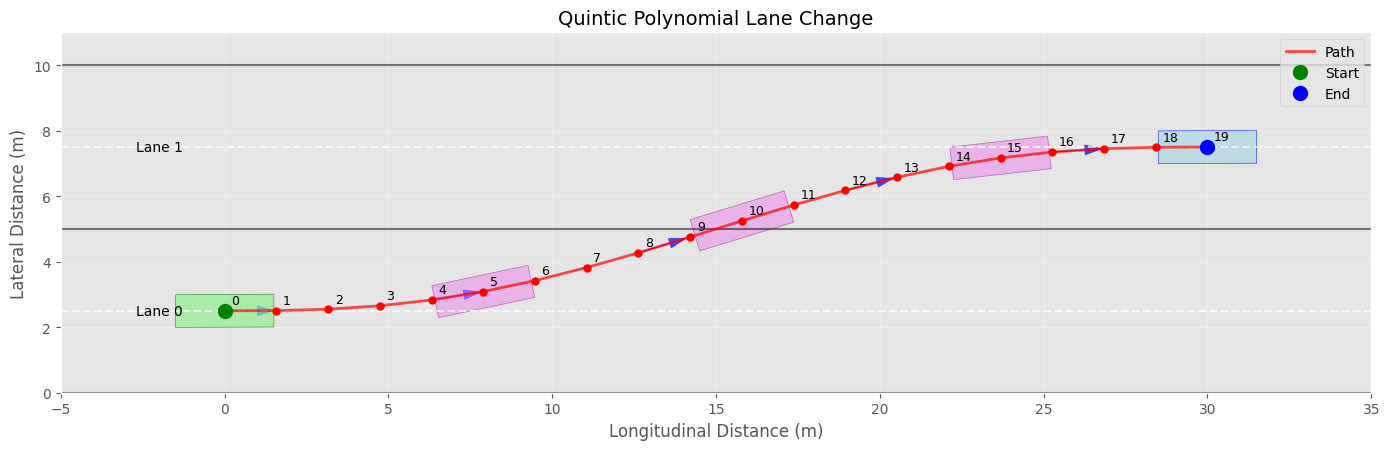

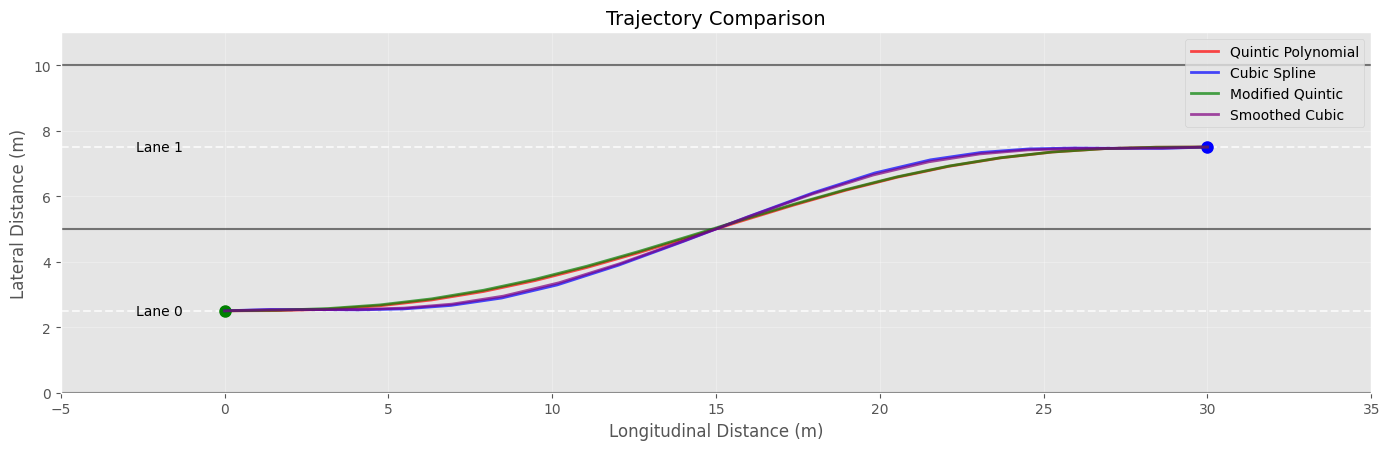

In [53]:
lane_width = 5
vehicle_length = 3
vehicle_width = 1
start_lane = 0
target_lane = 1
start_position = [0, lane_width / 2]  
longitudinal_distance = 30.0
num_points = 20

quintic_planner = QuinticPolynomialPlanner(lane_width, vehicle_length, vehicle_width)
cubic_planner = CubicSplinePlanner(lane_width, vehicle_length, vehicle_width)
planner = quintic_planner

waypoints, headings = planner.plan_trajectory(
    start_position=start_position,
    start_lane=start_lane,
    target_lane=target_lane,
    longitudinal_distance=longitudinal_distance,
    num_points=num_points
)


visualizer = TrajectoryVisualizer(lane_width, vehicle_length, vehicle_width)

fig1 = visualizer.visualize_trajectory(
    waypoints=waypoints,
    headings=headings,
    start_lane=start_lane,
    target_lane=target_lane,
    show_table=False,
    show_all_waypoints=True,
    title="Quintic Polynomial Lane Change"
)

fig2 = compare_planning_methods(
    start_position=start_position,
    start_lane=start_lane,
    target_lane=target_lane,
    longitudinal_distance=longitudinal_distance,
    num_points=num_points,
    lane_width=lane_width,
    vehicle_length=vehicle_length,
    vehicle_width=vehicle_width
)

plt.show()

# Metrics?

## Maximum Curvature

In [ ]:
def calculate_curvature(waypoints):
    if len(waypoints) < 3:
        return np.zeros(len(waypoints)), 0
    
    curvatures = np.zeros(len(waypoints))
    
    # Calculate derivatives using finite differences
    for i in range(1, len(waypoints)-1):
        dx_dt = (waypoints[i+1, 0] - waypoints[i-1, 0]) / 2
        dy_dt = (waypoints[i+1, 1] - waypoints[i-1, 1]) / 2
        
        d2x_dt2 = waypoints[i+1, 0] - 2*waypoints[i, 0] + waypoints[i-1, 0]
        d2y_dt2 = waypoints[i+1, 1] - 2*waypoints[i, 1] + waypoints[i-1, 1]

        # |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
        numerator = abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2)
        denominator = (dx_dt**2 + dy_dt**2)**(3/2)
        
        if denominator != 0:
            curvatures[i] = numerator / denominator

    curvatures[0] = curvatures[1]
    curvatures[-1] = curvatures[-2]
    
    return curvatures, np.max(curvatures)

## Maximum Lateral Acceleration

In [ ]:
def calculate_lateral_acceleration(waypoints, velocity=10.0):
    curvatures, _ = calculate_curvature(waypoints)
    
    # If velocity is constant (scalar)
    if np.isscalar(velocity):
        # Lateral acceleration = v² * curvature
        lat_accelerations = velocity**2 * curvatures
    else:
        # If velocity is provided (must match waypoints length)
        if len(velocity) != len(waypoints):
            raise ValueError("Velocity profile length must match waypoints length")
        lat_accelerations = np.zeros(len(waypoints))
        for i in range(len(waypoints)):
            lat_accelerations[i] = velocity[i]**2 * curvatures[i]
    
    return lat_accelerations, np.max(np.abs(lat_accelerations))